## Setup

In [2]:
# Get raw advent-of-code data
from aocd.models import Puzzle

puzzle = Puzzle(year=2025, day=2)
input_data = puzzle.input_data
examples = puzzle.examples

In [ ]:
# Imports
from math import ceil, log10
from timeit import timeit

import numpy as np


In [ ]:
# Parse input data
def parse_ranges(input_data: str) -> list[tuple[str, ...]]:
    """Parse input text from string to list of (start, end) tuples."""
    return [tuple(r.split("-")) for r in input_data.split(",")]


input_ranges = parse_ranges(input_data)
example_ranges = parse_ranges(examples[0].input_data)

## Part a

### Summary
I've implemented multiple approaches to solve part a. Starting with a straightforward string-based implementation, I then moved to a numerical approach to avoid string conversions, followed by a vectorized approach using NumPy for better performance. Finally, I developed a reversed approach that generates valid numbers directly, which proved to be the most efficient.

**Performance comparison**

| Implementation          | Time per run (ms) | Relative to string |
|-------------------------|--------------------|-------------------|
| String-based            | 435.0              | 1.0x              |
| Numerical               | 179.0              | 2.4x faster       |
| Vectorized              | 3.6                | 122x faster       |
| Reversed (optimized)    | 0.2                | 2177x faster      |

Below is a barebones version of the final reversed implementation used for part a. Check out the subsections for the other implementations.


In [ ]:
solution_a = 0

for r in input_ranges:
    # Unpack start and end
    start, end = map(int, r)

    if (start_len := ceil(log10(start + 1))) % 2 == 1:
        # If the start number has an odd length, we move to the next magnitude
        # For example, for '123' we move to 10 ** 3 = 1000
        start = 10 ** (start_len)

    if (end_len := ceil(log10(end + 1))) % 2 == 1:
        # Similarly, if the end is odd-length, we move one magnitude down
        end = 10 ** (end_len := end_len - 1)

    # If the range is empty after adjustment, return None
    if end <= start:
        continue

    # Add 1 to the halfway div to get the factor needed to generate repeated numbers of length
    # For example, for a 4-digit number like 1212, the repeating factor is 10 ** (4 // 2) + 1 = 101
    # 12*101 = 1212, a repeating number of length 4
    repeating_factor = 10 ** (end_len // 2) + 1

    # Generate all repeated numbers within the range
    candidates = {
        num * (repeating_factor)  # Construct the candidate number
        for num in range(  # Within the range of possible repeating parts
            -(-start // (repeating_factor)),  # Equivalent to ceiling division, to get smallest multiple >= start
            end // (repeating_factor) + 1,  # Largest multiple <= sub_end. Add 1 to include the endpoint
        )
    }

    solution_a += sum(candidates)

In [269]:
# Submit answer
puzzle.answer_a = solution_a

### String based approach
I started out with a string-based approach, checking each number in the range to see if the first half matches the second half. This worked fine but was a bit slow (taking bout half a second for the full input).

In [6]:
def calc_a_string_based(ranges: list[tuple[str, ...]]) -> int:
    """Calculate part A using string based approach."""
    solution = 0

    for r in ranges:
        start, end = r
        # Check if start number has odd-length (which means there are no possible invalid ids)
        if len(start) % 2 == 1:
            # Check if the end of the range is in the same power of 10.
            # If so, the whole range is odd-length, and thus valid
            if len(start) == len(end):
                continue
            # Move start to the next even-length number
            start = str(10 ** len(start))
        # Check if end number has odd-length
        elif len(end) % 2 == 1:
            end = str(10 ** (len(end) - 1))
        # Now both start and end have even-length
        for num in map(str, range(int(start), int(end) + 1)):
            half_len = len(num) // 2
            # If the two halves are equal, it's an invalid id, and we add it to the solution
            if int(num[:half_len]) == int(num[half_len:]):
                solution += int(num)

    return solution

In [245]:
# Correctness check
str(calc_a_string_based(example_ranges)) == examples[0].answer_a

True

In [7]:
# Performance check
string_based_time_a = timeit(lambda: calc_a_string_based(input_ranges), number=50) / 50
print(f"The string-based implementation takes {string_based_time_a * 1_000:.0f} ms per run.")

The string-based implementation takes 304 ms per run.


### Numerical approach
After that I implemented a numerical approach, which is much faster (taking about 2 milliseconds for the full input). This works by splitting each number into its two halves using division and modulus.

In [8]:
# Imports
from functools import lru_cache
from math import ceil, log10


In [12]:
def count_digits(n: int) -> int:
    """Count the number of digits in an integer.

    We add 1 to the number to account for the edge case that n is an exact power of 10.
    For example, for n = 1000: log10(1000) == 3, but n has 4 digits.
    However, log10(1000+1) > 3 -> ceil(log10(1001)) == 4, which is the correct number of digits.
    """
    return ceil(log10(n + 1))


@lru_cache(maxsize=15)
def find_halfway_div(n: int) -> int:
    """Find the halfway divisor for a number with n digits.

    For example, for n = 4 (1000 to 9999), the halfway divisor is 100
    as e.g. divmod (1234, 100) = 12, 34
    """
    return 10 ** (n // 2)


def adjust_ranges_a(r: tuple[str, ...]) -> tuple[int, ...] | None:
    """Adjust the ranges to be even-length only and find the halfway divisor."""
    # Unpack start and end
    start, end = map(int, r)

    if (start_len := count_digits(start)) % 2 == 1:
        # If the length is odd, we move to the next magnitude
        # For example, for '123' we move to 10 ** 3 = 1000
        start = 10 ** (start_len)

    if (end_len := count_digits(end)) % 2 == 1:
        # Similarly, if the end is odd-length, we move one magnitude down
        end = 10 ** (end_len := end_len - 1)

    # If the range is empty after adjustment, return None
    if end <= start:
        return None

    return start, end, find_halfway_div(end_len)


def calc_a_numerically(ranges: list[tuple[str, ...]]) -> int:
    """Calculate part A using numerical approach."""
    solution = 0

    for r in ranges:
        # Adjust the ranges and find the halfway divisor
        if (adjusted_range := adjust_ranges_a(r)) is None:
            continue
        start, end, halfway_div = adjusted_range

        for num in range(start, end + 1):
            # Divide each number in the adjusted range in two halves
            left, right = divmod(num, halfway_div)
            if left == right:
                solution += int(num)

    return solution

In [239]:
# Correctness check
str(calc_a_numerically(example_ranges)) == examples[0].answer_a

True

In [13]:
# Performance check
numerical_time_a = timeit(lambda: calc_a_numerically(input_ranges), number=50) / 50
print(f"The numerical implementation takes {numerical_time_a * 1_000:.0f} ms per run.")
print(f"This is {string_based_time_a / numerical_time_a:.1f}x faster than the string based implementation.")

The numerical implementation takes 85 ms per run.
This is 3.6x faster than the string based implementation.


### Vectorized approach
While the numerical approach was roughly 3 times faster than the string-based approach, I was curious how much vectorization would change.

In [14]:
# Imports
import numpy as np

In [15]:
def calc_a_vector_based(ranges: list[tuple[str, ...]]) -> int:
    """Vectorized approach to part A."""
    solution = 0

    for r in ranges:
        # Adjust the ranges and find the halfway divisor
        if (adjusted_range := adjust_ranges_a(r)) is None:
            continue
        start, end, halfway_div = adjusted_range

        # Use vectors to traverse the range
        np_range = np.arange(start, end + 1, dtype=np.int64)
        left, right = np.divmod(np_range, halfway_div)
        mask = left == right
        if mask.any():
            solution += int(np_range[mask].sum())

    return solution

In [248]:
# Correctness check
str(calc_a_vector_based(example_ranges)) == examples[0].answer_a

True

In [16]:
# Performance check
vector_based_time_a = timeit(lambda: calc_a_vector_based(input_ranges), number=100) / 100
print(f"The vectorized implementation takes {vector_based_time_a * 1_000:.1f} ms per run.")
print(
    f"This is {string_based_time_a / vector_based_time_a:.0f}x faster than the string based implementation "
    f"and {numerical_time_a / vector_based_time_a:.0f}x faster than the numerical implementation."
)

The vectorized implementation takes 3.8 ms per run.
This is 79x faster than the string based implementation and 22x faster than the numerical implementation.


### Reversed approach
Finally, I implemented a reversed approach, which generates candidate invalid ids based on the ranges instead of checking each id within a range. This turned out to be the fastest approach by far.

In [27]:
def calc_a_reversed(ranges: list[tuple[str, ...]]) -> int:
    """Reversed approach to part a."""
    solution = 0

    for r in ranges:
        # Adjust the ranges and find the halfway divisor
        if (adjusted_range := adjust_ranges_a(r)) is None:
            continue
        start, end, halfway_div = adjusted_range

        # Add 1 to the halfway div to get the factor needed to generate repeated numbers of length
        # e.g. for a 4-digit number like 1212, halfway_div is 100. 100+1 =101
        # 12*101 = 1212, a repeating number of length 4
        repeating_factor = halfway_div + 1

        # Generate all repeated numbers within the range
        invalid_ids = {
            num * (repeating_factor)  # Construct the candidate number
            for num in range(  # Within the range of possible repeating parts
                -(-start // (repeating_factor)),  # Equivalent to ceiling division, to get smallest multiple >= start
                end // (repeating_factor) + 1,  # Largest multiple <= sub_end. Add 1 to include the endpoint
            )
        }

        solution += sum(invalid_ids)

    return solution

In [25]:
# Correctness check
str(calc_a_reversed(example_ranges)) == examples[0].answer_a

True

In [28]:
# Performance check
reversed_based_time_a = timeit(lambda: calc_a_reversed(input_ranges), number=100) / 100
print(f"The reversed implementation takes {reversed_based_time_a * 1_000:.1f} ms per run.")
print(
    f"This is {string_based_time_a / reversed_based_time_a:.0f}x faster than the string based implementation,"
    f" {numerical_time_a / reversed_based_time_a:.0f}x faster than the numerical implementation,"
    f" and {vector_based_time_a / reversed_based_time_a:.0f}x faster than the vector-based implementation."
)

The reversed implementation takes 0.1 ms per run.
This is 2072x faster than the string based implementation, 582x faster than the numerical implementation, and 26x faster than the vector-based implementation.


## Part b

### Summary
Similar for part b, I tried multiple approaches, with a barebones version of the fastest implementation below

**Performance comparison**

| Implementation       | Time per run (ms) | Relative to string   |
|----------------------|--------------------|---------------------|
| String-based         | 2508               | 1.0x                |
| Numerical            | 170                | 14.8x faster        |
| Vectorized           | 32.9               | 76x faster          |
| Reversed (optimized) | 0.1                | 20909x faster       |

In [ ]:
@lru_cache(15)
def get_divisors(digit_count: int) -> set[int]:
    """Function that returns the divisors of a number that split a number with a given digit count into equal parts.

    For example, for digit_count = 6, the divisors are {1001, 10101, 111111} corresponding to
    splits of (3,3), (2,2,2), and (1,1,1,1,1,1)
    """
    factor_pairs = [(i, digit_count // i) for i in range(1, digit_count) if digit_count % i == 0]
    divisors = set()
    for part_len, part_count in factor_pairs:
        d = 0
        for part in range(part_count):
            d += int(10 ** ((part_len) * (part)))
        divisors.add(d)
    return divisors


solution_b = 0

for r in input_ranges:
    # Unpack start and end
    start, end = map(int, r)

    # Split the range into two ranges if they cross an order of magnitude

    # NOTE: This only works for ranges that are at most one order of magnitude apart.
    # This is the case for the input data, but the solution can be easily extended to cover larger ranges if needed
    if (start_len := count_digits(start)) < (end_len := count_digits(end)):
        sub_ranges = [(start, 10**start_len - 1, start_len), (10**start_len, end, end_len)]
    else:
        # Otherwise, just use the original range
        sub_ranges = [(start, end, start_len)]

    # Check each sub-range
    for sub_start, sub_end, digit_count in sub_ranges:
        candidates = {
            num * d  # Construct the candidate number
            for d in get_divisors(digit_count)  # Across all divisors
            for num in range(  # Within the range of possible repeating parts
                -(-sub_start // d),  # Equivalent to ceiling division, to get smallest multiple >= sub_start
                sub_end // d + 1,  # Largest multiple <= sub_end. Add 1 to include the endpoint
            )
        }

        solution_b += sum(candidates)

In [277]:
# Submit answer
puzzle.answer_b = solution_b

### String-based approach
Now we need to check whether an ID can be split into equal-length parts that are all the same. For each factor `f` of `len(id)` with `f < len(id)`, split the ID into parts of length `f`; if any split produces all-equal parts the ID is invalid.

Example: `id = 12121212`
- `len = 8` → try `f = 1, 2, 4`
- `f = 2` → `['12','12','12','12']` → all equal → ID is invalid

Algorithm
- For each candidate ID (or the even-length subset), find `L = len(id)` and try factors `f < L`.
- Split into parts of length `f` and check if all(parts == parts[0]).
- Count the ID as invalid if any `f` matches.

In [34]:
# Functions
@lru_cache(25)
def get_factors(n: int) -> set:
    """Simple function to return the factors of a number n as a set.

    Note that we exclude the number itself from the result, as we only need to check if an id of length n
    can be split into multiple smaller parts of length m < n
    """
    if n <= 0:
        msg = "Input must be a positive integer."
        raise ValueError(msg)
    return {factor for i in range(1, int(n**0.5) + 1) if n % i == 0 for factor in (i, n // i)} - {n}


def check_split_str_based(n: int) -> bool:
    """Check if a number can be split into n equal parts that are all the same by using string conversion."""
    # Get the factors of the digit count of n
    n_str = str(n)
    factors = get_factors(n_len := len(n_str))

    for f in factors:
        init_part = None

        # Divide n into f-sized parts
        for i in range(0, n_len, f):
            # Get the current part
            new_part = n_str[i : i + f]

            # Get the initial part if not set
            if init_part is None:
                init_part = new_part

            # Compare with the initial part, move to the next factor if not equal
            elif new_part != init_part:
                break
        else:
            # If we did not break, all parts are equal
            return True

    # If no factor worked, return False
    return False


def calc_b_string_based(ranges: list[tuple[str, ...]]) -> int:
    """Calculate part B using string based approach."""
    solution = 0

    for r in ranges:
        # Unpack start and end
        start, end = map(int, r)

        # Check each number in the range
        for n in range(start, end + 1):
            if check_split_str_based(n):
                solution += int(n)

    return solution

In [52]:
# Correctness check
str(calc_b_string_based(example_ranges)) == examples[0].answer_b

True

In [33]:
# Performance check
string_based_time_b = timeit(lambda: calc_b_string_based(input_ranges), number=5) / 5
print(f"The string-based implementation takes {string_based_time_b * 1_000:.0f} ms per run.")

The string-based implementation takes 1950 ms per run.


### Numerical approach

In [ ]:
@lru_cache(15)
def get_divisors(digit_count: int) -> set[int]:
    """Function that returns the divisors of a number that split a number with a given digit count into equal parts.

    Note that we exclude the 1-divisor from the result, as we don't need to check if an id can be split into 1 part.
    Also note that this function is suboptimal for large n, where we should only look for factors up to the square root
    of n, but it is sufficient for our use case where n is at most the number of digits in the largest id (< 15).

    Example:
    Let's consider the numbers 1212 and 3333, both with digit count 4:
    >>> get_divisors(4)
    {1111, 101}

    You can interpret this as:
        3333 / 1111 = 3
        1212 / 101 = 12
    """
    if digit_count <= 0:
        msg = "Input must be a positive integer."
        raise ValueError(msg)

    factor_pairs = [(i, digit_count // i) for i in range(1, digit_count) if digit_count % i == 0]
    divisors = set()
    for part_len, part_count in factor_pairs:
        d = 0
        for part in range(part_count):
            # Find the divisor to split the number
            d += int(10 ** ((part_len) * (part)))
        divisors.add(d)
    return divisors


def adjust_ranges_b(r: tuple[str, ...]) -> list[tuple[int, ...]]:
    """Adjust the ranges for part b."""
    # Unpack start and end
    start, end = map(int, r)

    # Split the range into two ranges if they cross an order of magnitude

    # NOTE: This only works for ranges that are at most one order of magnitude apart.
    # This is the case for the input data, but the solution can be easily extended to cover larger ranges if needed
    if (start_len := count_digits(start)) < (end_len := count_digits(end)):
        return [(start, 10**start_len - 1, start_len), (10**start_len, end, end_len)]

    # Otherwise, just use the original range
    return [(start, end, start_len)]


def calc_b_numerical(ranges: list[tuple[str, ...]]) -> int:
    """Solution to part b."""
    solution = 0

    for r in ranges:
        # Adjust the ranges for part b
        sub_ranges = adjust_ranges_b(r)

        # Check each number in the sub-ranges
        for sub_start, sub_end, digit_count in sub_ranges:
            divisors = get_divisors(digit_count)

            for n in range(sub_start, sub_end + 1):
                for d in divisors:
                    if n % d == 0:
                        solution += int(n)
                        break

    return solution


In [271]:
# Correctness check
str(calc_b_numerical(example_ranges)) == examples[0].answer_b

True

In [46]:
# Performance check
numerical_time_b = timeit(lambda: calc_a_numerically(input_ranges), number=50) / 50
print(f"The numerical implementation takes {numerical_time_b * 1_000:.0f} ms per run.")
print(f"This is {string_based_time_b / numerical_time_b:.1f}x faster than the string based implementation.")

The numerical implementation takes 86 ms per run.
This is 22.7x faster than the string based implementation.


### Vectorized approach

In [48]:
@lru_cache(15)
def get_divisor_array(digit_count: int) -> np.ndarray:
    """Return a numpy array of divisors for a given digit count."""
    return np.array(list(get_divisors(digit_count)), dtype=np.int64)


def calc_b_vector_based(ranges: list[tuple[str, ...]]) -> int:
    """Vector-based approach to part b."""
    solution = 0

    for r in ranges:
        # Adjust the ranges for part b
        sub_ranges = adjust_ranges_b(r)

        # Check each number in the sub-ranges
        for sub_start, sub_end, digit_count in sub_ranges:
            # Get divisors as a numpy array
            divisors = get_divisor_array(digit_count)

            # Cast the sub-range to a numpy array
            np_range = np.arange(sub_start, sub_end + 1)

            # Calculate remainders
            remainders = np.mod(np_range[:, None], divisors[None, :])

            # The invalid ids are those where any remainder is zero, i.e. they divide neatly into a repeating part
            mask = (remainders == 0).any(axis=1)
            if mask.any():
                solution += int(np_range[mask].sum())

    return solution

In [273]:
# Correctness check
str(calc_b_vector_based(example_ranges)) == examples[0].answer_b

True

In [49]:
# Performance check
vector_based_time_b = timeit(lambda: calc_b_vector_based(input_ranges), number=100) / 100
print(f"The vectorized implementation takes {vector_based_time_b * 1_000:.1f} ms per run.")
print(
    f"This is {string_based_time_b / vector_based_time_b:.0f}x faster than the string based implementation "
    f"and {numerical_time_b / vector_based_time_b:.0f}x faster than the numerical implementation."
)

The vectorized implementation takes 33.4 ms per run.
This is 58x faster than the string based implementation and 3x faster than the numerical implementation.


### Reversed approach

Thus far, I've checked for each number in a range wether it can be split into multiple parts. However, we could try to instead generate all possible repeated numbers within a range and just add those, without checking each number.

In [50]:
def calc_b_reversed(ranges: list[tuple[str, ...]]) -> int:
    """Reversed approach to part b."""
    solution = 0

    for r in ranges:
        # Adjust the ranges for part b
        sub_ranges = adjust_ranges_b(r)

        # Check each sub-range
        for sub_start, sub_end, digit_count in sub_ranges:
            candidates = {
                num * d  # Construct the candidate number
                for d in get_divisors(digit_count)  # Across all divisors
                for num in range(  # Within the range of possible repeating parts
                    -(-sub_start // d),  # Equivalent to ceiling division, to get smallest multiple >= sub_start
                    sub_end // d + 1,  # Largest multiple <= sub_end. Add 1 to include the endpoint
                )
            }

            solution += sum(candidates)

    return solution

In [197]:
# Correctness check
str(calc_b_reversed(example_ranges)) == examples[0].answer_b

True

In [51]:
# Performance check
reversed_time_b = timeit(lambda: calc_b_reversed(input_ranges), number=1000) / 1000
print(f"The reversed implementation takes {reversed_time_b * 1_000:.1f} ms per run.")
print(
    f"This is {string_based_time_b / reversed_time_b:.0f}x faster than the string based implementation "
    f", {numerical_time_b / reversed_time_b:.0f}x faster than the numerical implementation."
    f", and {vector_based_time_b / reversed_time_b:.0f}x faster than the vector based implementation."
)

The reversed implementation takes 0.1 ms per run.
This is 23719x faster than the string based implementation , 1045x faster than the numerical implementation., and 407x faster than the vector based implementation.


<Axes: xlabel='x_var', ylabel='y_var'>

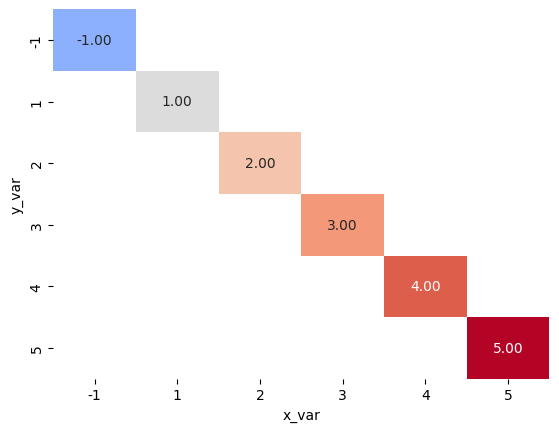

In [ ]:
from matplotlib.colors import CenteredNorm
import seaborn as sns
import pandas as pd

cmap = sns.color_palette("coolwarm", as_cmap=True)
norm = CenteredNorm(1.0)
df = pd.DataFrame(
    {
        "x_var": [-1, 1, 2, 3, 4, 5],
        "y_var": [-1, 1, 2, 3, 4, 5],
        "speedup": [-1, 1, 2, 3, 4, 5],
    }
)
pivot = df.pivot_table(index="y_var", columns="x_var", values="speedup", aggfunc="mean")
sns.heatmap(
    pivot,
    cmap="coolwarm",
    norm=norm,
    cbar=False,
    annot=(pivot.size <= 64),
    fmt=".2f",
)